In [2]:
# libs
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl

In [5]:
# load the observations
sites_path = '/glade/u/home/jhenao/atm746/other_data/'


#46005h2024.txt
#46014h2024.txt
#46015h2024.txt
#46022h2024.txt
#46029h2024.txt
#46050h2024.txt
#46089h2024.txt
#oakland_sounding.txt
#salem_sound.txt
##stations.csv

esta = pd.read_csv(
    sites_path+'stations.csv',
    comment='#'
)
esta


,buoy,latitude,longitude
0,46089,45.928,-125.815
1,46050,44.679,-124.535
2,46029,46.148,-124.508
3,46022,40.716,-124.540
4,46015,42.754,-124.839
5,46014,39.225,-123.980
6,46005,46.143,-131.090


In [82]:
columns = [
    "YY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "GST", "WVHT", "DPD", "APD",
    "MWD", "PRES", "ATMP", "WTMP", "DEWP", "VIS", "TIDE"
]

def read_buoy_data(site):
    df = pd.read_csv(
        sites_path+site+'h2024.txt',
        sep='\s+',
        comment="#",
        names=columns,
        header=None,
        na_values=[9999.0, 9999]
    )

    df_datetime = df[["YY", "MM", "DD", "hh", "mm"]].rename(
        columns={"YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}
    )

    df["datetime"] = pd.to_datetime(df_datetime )
    
    return df[['datetime','PRES']]



def get_lat_lon_site(site):
    tmp = esta[esta['buoy']==site]
    return tmp.latitude.values[0], tmp.longitude.values[0]

In [57]:
varneed = ['XLAT', 'XLONG', 'PSFC']

def get_time_series(path: str, lat_p: float, lon_p: float) -> np.ndarray:
    """
    gets the path, load the files, get the time series
    at the closest grid cell and returns it
    """
    # get file list at path
    file_list = sorted(glob.glob(path+"wrfout_d02*"))
    # open netcdf files
    ds_mf = xr.open_mfdataset(
        file_list, 
        combine='nested',
        concat_dim='Time',
        drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in varneed],
        coords='minimal',
        compat='override'
    )
    # get lat lon
    lat = ds_mf['XLAT'].isel(Time=0)  # (south_north, west_east)
    lon = ds_mf['XLONG'].isel(Time=0)
    # Compute distance (squared) to every grid point
    dist_sq = (lat - lat_p)**2 + (lon - lon_p)**2
    # get the indexes lat, lon of the closest grid
    min_dist_idx = dist_sq.argmin(dim=['south_north', 'west_east'])
    iy = int(min_dist_idx['south_north'])
    ix = int(min_dist_idx['west_east'])
    # add convective and parameterized precip and get it in the station coords
    pr_arr_ts = ds_mf['PSFC'].isel(south_north=iy, west_east=ix).values

    return pr_arr_ts
    

In [ ]:
file_list = sorted(glob.glob(mp9_bl8_path+"wrfout_d02*"))
ds_for_time = xr.open_mfdataset(
        file_list, 
        combine='nested',
        concat_dim='Time',
        drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in ['XTIME']],
        coords='minimal',
        compat='override'
)

times = ds_for_time['XTIME'].values

In [84]:
def plot_pressure(df_site, site, psfc_hpa):

    plt.figure(figsize=(8, 4))
    
    plt.xlim(pd.Timestamp("2024-11-18"), pd.Timestamp("2024-11-25"))
    
    plt.ylim(940,1040)
    
    # from station
    plt.plot(df_site['datetime'], df_site['PRES'], label="Observation", linewidth=3, color='black')
    # from wrf
    plt.plot(
        times, 
        psfc_hpa, 
        label='WRF',
        color='red',
        linestyle='--',
        linewidth=2
    )
    
    plt.xlabel('Time')
    plt.ylabel('Surface Pressure [hPa]')
    plt.title(f"Surface pressure at site {site} ")
    
    plt.legend()
    
    plt.grid(True)

    plt.show()

46089


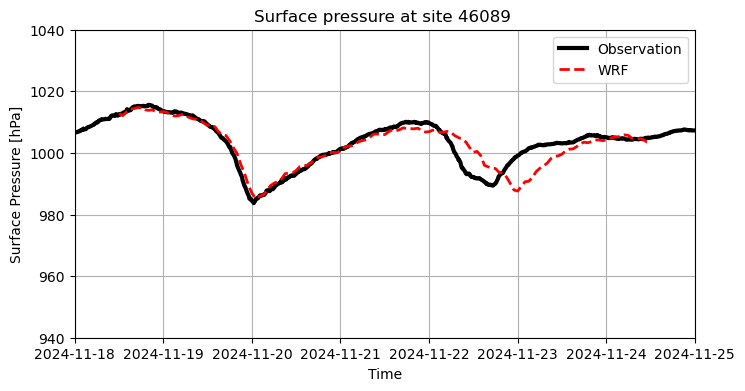

46050


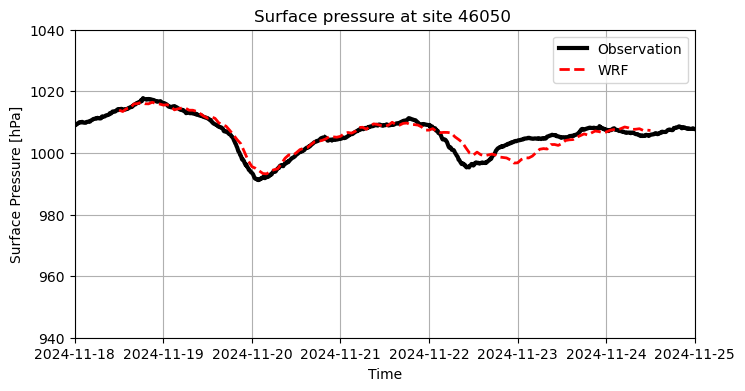

46029


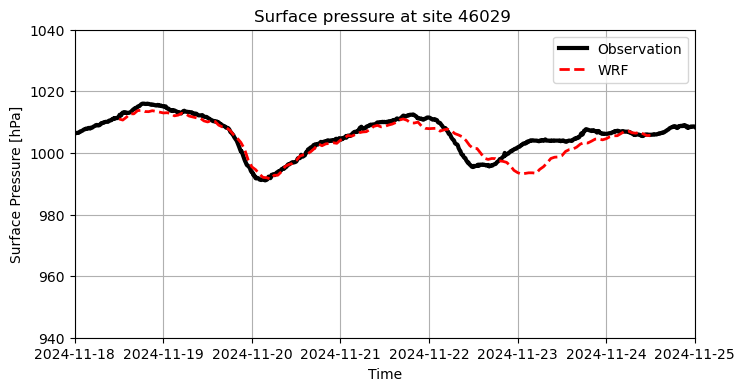

46022


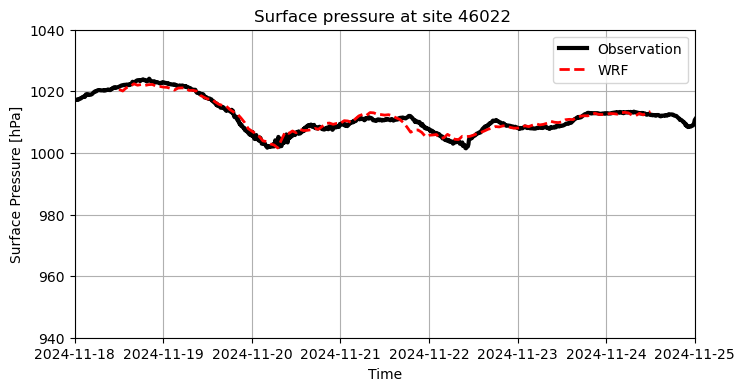

46015


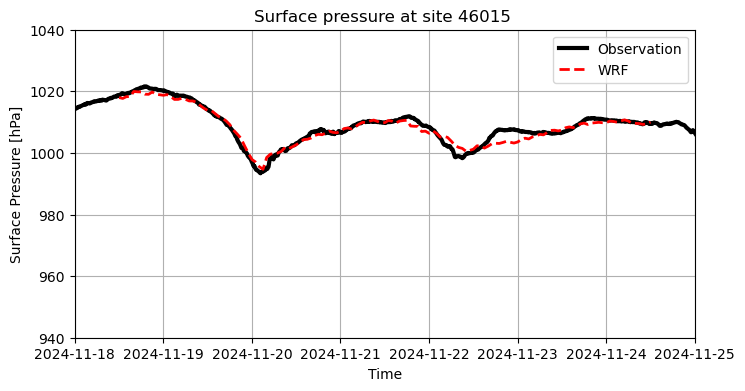

46014


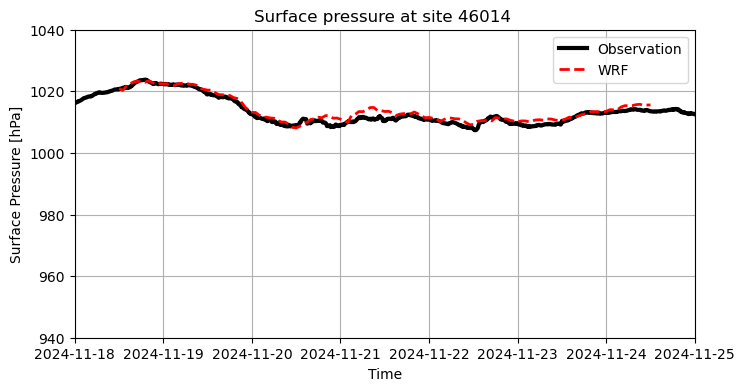

46005


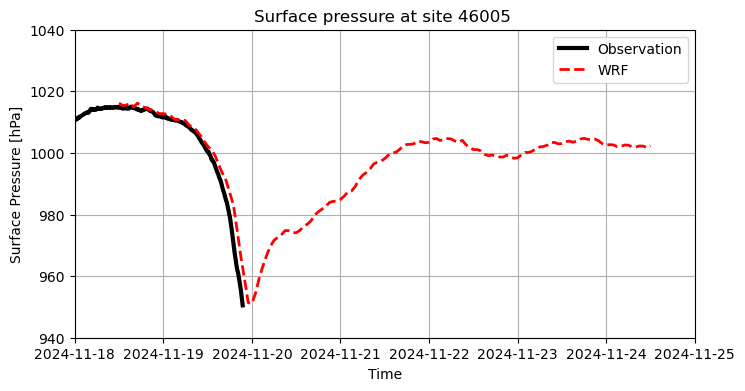

In [97]:
mp9_bl8_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl8/'
#mp6_bl1_path = '/glade/derecho/scratch/tfriberg/atm746/ar_mp6_bl1/' #Tucker


sites = esta['buoy'].tolist()




for site in sites:
    print(str(site))
    df_site = read_buoy_data(str(site))
    lat_s, lon_s = get_lat_lon_site(site)
    psfc_pa = get_time_series(mp9_bl8_path, lat_s, lon_s)
    psfc_hpa=psfc_pa/100
    plot_pressure(df_site, site, psfc_hpa)
    

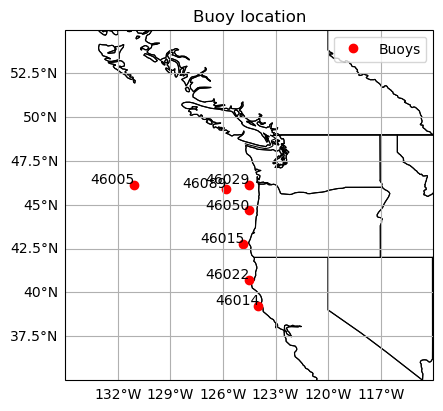

In [95]:

# bounding box limit

lon_min = -135
lon_max = -114
lat_min = 35
lat_max = 55


# make lists of lat lon
buoy_lons = esta['longitude'].tolist()
buoy_lats = esta['latitude'].tolist()
buoy_labe = esta['buoy'].tolist()




# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.PlateCarree()

fig, ax = plt.subplots(
    figsize=(8, 4), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)

## bounding box limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max]) 

# add coastline, states and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)


## 
plt.plot(buoy_lons, buoy_lats, 'ro', transform=ccrs.PlateCarree(),label='Buoys')

for lon, lat, label in zip(buoy_lons, buoy_lats, buoy_labe):
    ax.text(lon + 0.05, lat + 0.09, label, transform=ccrs.PlateCarree(),
            ha='right',
            fontsize=10, color='black')


grid = ax.gridlines(draw_labels=True)
grid.right_labels = False
grid.top_labels = False

plt.legend()

plt.title('Buoy location')

plt.show()